In [1]:
import os, gzip, zlib, json, math, warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import matplotlib.colors as colors
import pandas as pd
from scipy.stats import norm, chi2
from tqdm import tqdm
from pathlib import Path
from collections import defaultdict
from statsmodels.tsa.stattools import acf
from scipy.stats import pearsonr

from scipy.stats import ks_2samp, combine_pvalues

# define matplotlib style
mpl.style.use("classic")
mpl.rc("xtick", labelsize=15)
mpl.rc("ytick", labelsize=15)
mpl.rc("xtick.major", size=14, width=2)
mpl.rc("xtick.minor", size=7, width=2, visible=True)
mpl.rc("ytick.major", size=14, width=2)
mpl.rc("ytick.minor", size=7, width=2, visible=True)
mpl.rc("lines", linewidth=2, markersize=5)
mpl.rc("axes", linewidth=2, labelsize=15, labelpad=2.5)
mpl.rc("legend", fontsize=15, loc="best", frameon=True, numpoints=1)

mpl.rc("font", family="STIXGeneral")
mpl.rc("mathtext", fontset="stix")

/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_66630/3075964577.py:30: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(fn, delim_whitespace=True,
/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_66630/3075964577.py:30: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(fn, delim_whitespace=True,
/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_66630/3075964577.py:30: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(fn, delim_whitespace=True,
/var/folders/1r/x7pmt5qs61j4zkk17bl3rg0m0000gn/T/ipykernel_66630/3075964577.py:30: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a futu

Loaded 1,636 coincident events from 10 angles.

=== Summary (±1 SE) ===
             statistic    estimate  expected      ±1 SE
        P(1) (monobit)     0.50795       0.5   0.012316
Shannon entropy (bits)     0.99982         1   0.000838
gzip compression ratio      1.1122         1 4.4411e-16
       LZ78 complexity         258       258     1.0963
   mean|ACF| (lag ≤50)    0.017167  0.019726  0.0023984
   slope P(1) vs angle -0.00071579         0 0.00051315

Saved summary_statistics.csv

=== Per-test σ-significance and combined result ===
             statistic   estimate     ±1 SE  z-score (σ)
        P(1) (monobit)     0.5079   0.01232       0.6452
Shannon entropy (bits)     0.9998  0.000838      -0.2174
gzip compression ratio      1.112 4.441e-16            0
       LZ78 complexity        258     1.096            0
   mean|ACF| (lag ≤50)    0.01717  0.002398       -1.067
   slope P(1) vs angle -0.0007158 0.0005132       -1.395

Fisher Z = 0.2548  →  p = 0.7989
Stouffer Z (two-side

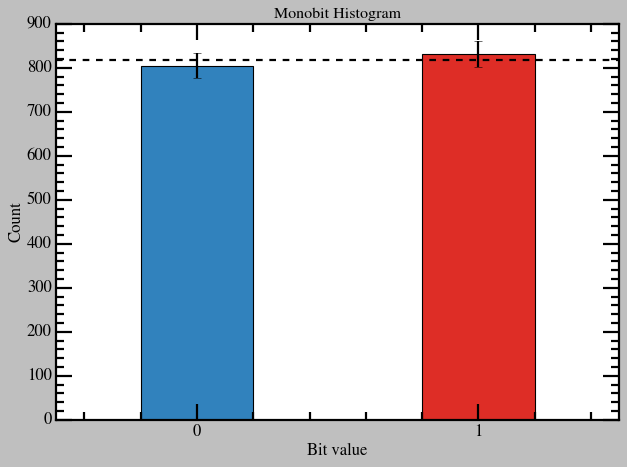

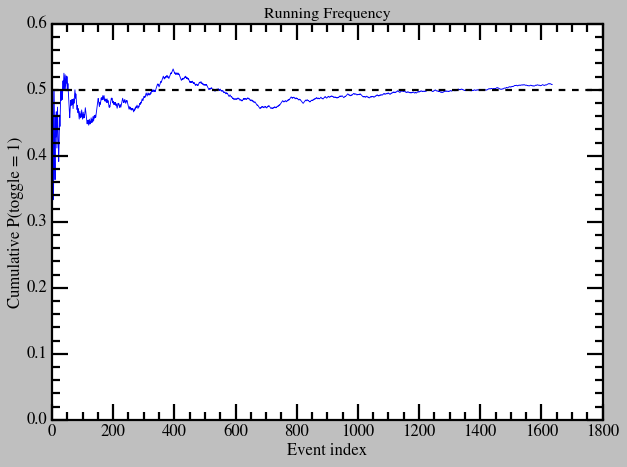

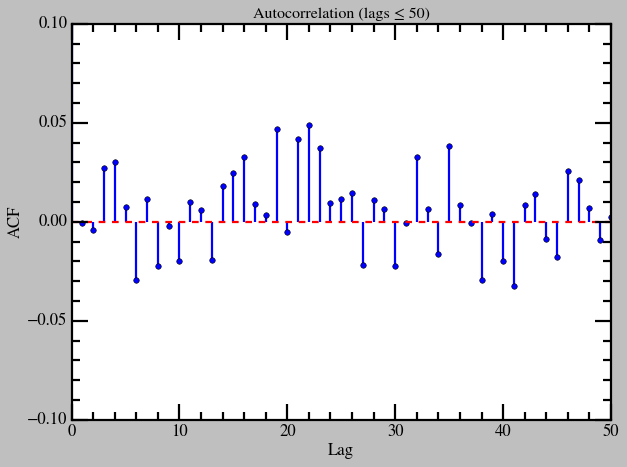

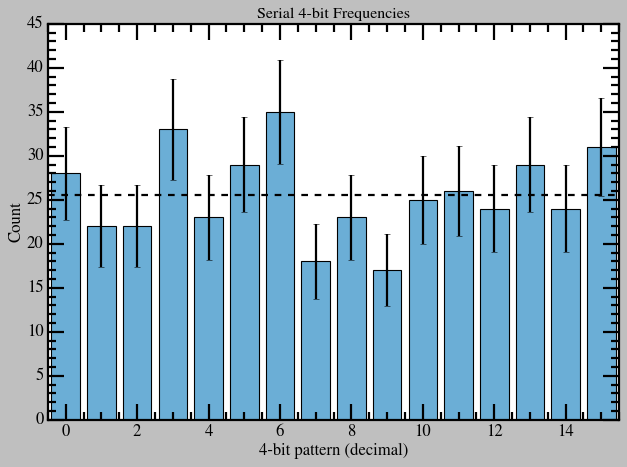

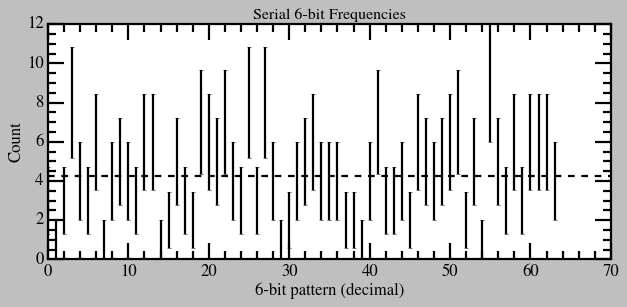

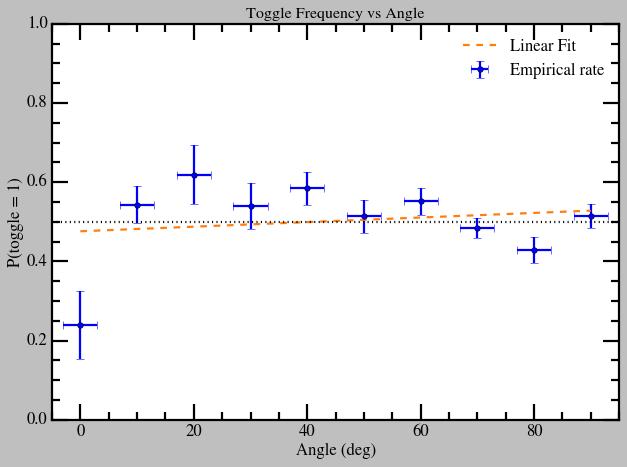

In [3]:
# ──────────────────────────────────────────────────
# 0.  I/O: file→angle mapping
# ──────────────────────────────────────────────────
DATA_DIR = Path("data")          # put your .txt files here
ANGLE_STEP = 10                  # 0°,10°,…90°
FILE_TEMPLATE = "{a}.txt"        # 0.txt, 10.txt, …
COLS = [
    "EventNumber", "Time", "Date", "TimeStamp_ms",
    "ADC1", "ADC2", "SiPM_mV", "Temp_C",
    "Pressure_Pa", "DeadTime_us", "Coincident", "ID"
]
PLOTS = Path("report/figure")
PLOTS.mkdir(exist_ok=True)

# build mapping automatically so you never forget a file
file_to_angle = {
    DATA_DIR/FILE_TEMPLATE.format(a=a): a
    for a in range(0, 91, ANGLE_STEP)
}

# ──────────────────────────────────────────────────
# 1.  Read & pre-process
# ──────────────────────────────────────────────────
dfs = []
for fn, ang in file_to_angle.items():
    if not fn.exists():
        warnings.warn(f"{fn} missing – skipped.")
        continue

    df = pd.read_csv(fn, delim_whitespace=True,
                     comment="#", header=None, names=COLS)

    # keep coincidences only
    df = df[df["SiPM_mV"] > 80].copy()
    df = df[df["Coincident"] == 1].copy()
    if df.empty:
        warnings.warn(f"No coincidences in {fn}.")
        continue

    df["toggle"] = (df["TimeStamp_ms"] & 1).astype(int)
    df["angle"]  = ang
    dfs.append(df)

if not dfs:
    raise RuntimeError("No data loaded!")

data = pd.concat(dfs, ignore_index=True)
data.sort_values(["Date", "Time"], inplace=True, ignore_index=True)

bits   = data["toggle"].to_numpy(dtype=np.int8)
angles = data["angle"].to_numpy(dtype=np.int16)
n      = bits.size
print(f"Loaded {n:,} coincident events from {data['angle'].nunique()} angles.")

# ──────────────────────────────────────────────────
# 2.  Helper: bootstrap SE
# ──────────────────────────────────────────────────
def bootstrap_stat(x, stat_fn, B=10000, block=None, random=np.random.default_rng()):
    """
    Return (statistic, SE) where SE is √Var_hat via B bootstrap replicates.
    If block is not None, use moving-block bootstrap with block length `block`.
    """
    N   = len(x)
    idx = np.arange(N)
    s0  = stat_fn(x)                        # statistic on original data
    reps = np.empty(B)

    for b in range(B):
        if block is None:                   # iid resample
            resample = random.choice(idx, size=N, replace=True)
        else:                               # moving-block bootstrap
            k = math.ceil(N / block)
            blocks = random.choice(idx[:-block], size=k, replace=True)
            resample = np.hstack([np.arange(i, i+block) for i in blocks])[:N]
        reps[b] = stat_fn(x[resample])

    se = reps.std(ddof=1)
    return s0, se

# ──────────────────────────────────────────────────
# 3.  Statistics + uncertainties
# ──────────────────────────────────────────────────
# 3.1 monobit proportion
# obs_mono = bits.sum() / n
prop_1, se_prop = bootstrap_stat(bits, np.mean)

# 3.2 Shannon entropy (plug-in) with delta-method SE
def shannon(x):
    p = x.mean()
    if p in (0, 1):
        return 0.0
    return -(p*np.log2(p) + (1-p)*np.log2(1-p))

# obs_H = shannon(bits)

H, se_H = bootstrap_stat(bits, shannon)

# 3.3 gzip compression ratio
def gzip_cr(x):
    # pack bits→bytes
    pad   = (-len(x)) % 8
    if pad:                              # pad with zeros so len % 8 == 0
        x = np.concatenate([x, np.zeros(pad, dtype=x.dtype)])
    by    = np.packbits(x).tobytes()
    comp  = gzip.compress(by, compresslevel=9)
    return len(comp) / len(by)

# obs_cr = gzip_cr(bits)

cr, se_cr = bootstrap_stat(bits, gzip_cr, B=10000)   # compression is slow – 300 is plenty

# 3.4 Lempel–Ziv complexity
def lz_complexity(bit_arr):
    s = "".join(map(str, bit_arr.tolist()))
    i, n, comp, d = 0, len(s), 0, set()
    while i < n:
        L = 1
        while i+L <= n and s[i:i+L] in d:
            L += 1
        d.add(s[i:i+L])
        comp += 1
        i += L
    return comp

# obs_lz = lz_complexity(bits)

lz, se_lz = bootstrap_stat(bits, lz_complexity, B=10000)

# 3.5 first 50-lag autocorrelation (we record max|r_k|)
acf_vals = acf(bits, nlags=50, fft=True)
obs_meanacf  = np.abs(acf_vals[1:]).mean()       # ignore k=0
# bootstrap with moving blocks (length≈√N) so dependence preserved
block    = int(np.sqrt(n))
meanacf, se_meanacf = bootstrap_stat(bits, lambda x: np.abs(acf(x, nlags=50, fft=True)[1:]).mean(),
                                   B=10000, block=block)

expected_meanacf = 1.0 / np.sqrt(n) * np.sqrt(2/np.pi)

# ──────────────────────────────────────────────────
# 4.  Angle dependence: slope ± SE from bootstrap
# ──────────────────────────────────────────────────
angle_df      = pd.DataFrame({"angle": angles, "bit": bits})
group         = angle_df.groupby("angle")["bit"]
rate_by_angle = group.mean()
angles_unique = rate_by_angle.index.to_numpy()
rates         = rate_by_angle.to_numpy()

slope, intercept = np.polyfit(angles_unique, rates, 1)

def slope_stat(arr):
    a, b = arr
    return np.polyfit(a, b, 1)[0]

# build array of (angle,bit) pairs so we can resample rows
anglebit = angle_df[["angle", "bit"]].to_numpy()
slp, se_slp = bootstrap_stat(anglebit,
                             lambda ab: slope_stat((ab[:,0], ab[:,1])),
                             B=10000)

# ──────────────────────────────────────────────────
# 5.  Pretty summary
# ──────────────────────────────────────────────────
summary = pd.DataFrame({
    "statistic": [
        "P(1) (monobit)",
        "Shannon entropy (bits)",
        "gzip compression ratio",
        "LZ78 complexity",
        "mean|ACF| (lag ≤50)",
        "slope P(1) vs angle"
    ],
    # "observed": [obs_mono, obs_H, obs_cr, obs_lz, obs_maxacf, slope],
    "estimate": [prop_1, H, cr, lz, meanacf, slp],
    "expected": [0.5, 1.0, 1.0, lz, expected_meanacf, 0.0],
    "±1 SE":    [se_prop, se_H, se_cr, se_lz, se_meanacf, se_slp]
})
print("\n=== Summary (±1 SE) ===")
print(summary.to_string(index=False, float_format=lambda x: f"{x:0.5g}"))

# also save for LaTeX tables etc.
summary.to_csv("summary_statistics.csv", index=False)
print("\nSaved summary_statistics.csv")

# ──────────────────────────────────────────────────
# 5 bis.  Sigma (z-score) for each test + combined-σ
# ──────────────────────────────────────────────────
from scipy.stats import norm

# convert to z = (obs – μ₀) / σ_est  -------------------------------
sigmas, pvals = [], []
eps = 1e-12

for _, row in summary.iterrows():
    mu0 = row["expected"]
    se  = row["±1 SE"]
    if se < eps:               # uninformative test
        z, p = 0.0, 1.0
    else:
        z = (row["estimate"] - mu0) / se
        p = 2 * norm.sf(abs(z))      # two-sided
    sigmas.append(z)
    pvals.append(p)

summary["z-score (σ)"]  = sigmas
summary["two-sided p"]  = pvals

sigma_s = np.array(sigmas)
# sigma_s = sigma_sh[sigma_sh != 0]          # only positive z-scores
pvals_s = np.array(pvals)
# pvals_s = pvals_s[sigma_sh != 0]         # only positive z-scores

# ---- combine (Fisher) ----
fisher_stat = -2 * np.sum(np.log(pvals_s))           #   X_Fisher
df          = 2 * len(pvals_s)                       #   2m  degrees of freedom
p_comb_fisher = chi2.sf(fisher_stat, df)             #   combined two-sided p
z_comb_fisher    = norm.isf(p_comb_fisher / 2.0)        #   Fisher Z (two-sided)

# ---- combine (Stouffer, two-sided) ----

z_stouffer = np.sum(np.sign(sigma_s) * norm.isf(pvals_s / 2)) / np.sqrt(len(pvals_s))
p_stouffer = 2 * norm.sf(abs(z_stouffer))

print("\n=== Per-test σ-significance and combined result ===")
print(summary[["statistic", "estimate", "±1 SE", "z-score (σ)"]]
      .to_string(index=False, float_format=lambda x: f"{x:0.4g}"))

print(f"\nFisher Z = {z_comb_fisher:0.4g}  →  p = {p_comb_fisher:0.4g}")
print(f"Stouffer Z (two-sided) = {z_stouffer:0.4g}  →  p = {p_stouffer:0.4g}")

# also save the augmented table
summary.to_csv("summary_statistics_with_z.csv", index=False)

# ──────────────────────────────────────────────────
# 6.  Publication-quality plots
#     (only those cited in the manuscript)
# ──────────────────────────────────────────────────

# 7.1 Monobit histogram + Poisson errors ───────────
fig, ax = plt.subplots()
counts = np.bincount(bits, minlength=2)
ax.bar([0, 1], counts, width=0.4, color=["#3182bd", "#de2d26"])
ax.errorbar([0, 1], counts, yerr=np.sqrt(counts),
            fmt="none", ecolor="k", capsize=4)
ax.axhline(counts.mean(), ls="--", color="k")
ax.set_xticks([0, 1])
ax.set_xlim(-0.5, 1.5)
ax.set_xlabel("Bit value")
ax.set_ylabel("Count")
ax.set_title("Monobit Histogram")
fig.tight_layout()
fig.savefig(PLOTS / "monobit_histogram.png", dpi=300)

# 7.2 Cumulative frequency of “1”s ────────────────
fig, ax = plt.subplots()
cum_frac = np.cumsum(bits) / np.arange(1, n + 1)
ax.plot(cum_frac, lw=0.8)
ax.axhline(0.5, ls="--", color="k")
ax.set_xlabel("Event index")
ax.set_ylabel("Cumulative P(toggle = 1)")
ax.set_title("Running Frequency")
fig.tight_layout()
fig.savefig(PLOTS / "running_frequency.png", dpi=300)

# 7.3 Autocorrelation (lags ≤ 50) ─────────────────
fig, ax = plt.subplots()
lags = np.arange(len(acf_vals))
ax.stem(lags, acf_vals, basefmt=" ")
ax.axhline(0, ls="--", color="r")
ax.set_ylim(-0.1, 0.1)
ax.set_xlabel("Lag")
ax.set_ylabel("ACF")
ax.set_title("Autocorrelation (lags ≤ 50)")
fig.tight_layout()
fig.savefig(PLOTS / "acf_bits.png", dpi=300)

# 7.4 Serial 4-bit frequencies ────────────────────
even_n = (n // 4) * 4
quads  = bits[:even_n].reshape(-1, 4)
labels4 = np.dot(quads, [8, 4, 2, 1])
cnt4   = np.bincount(labels4, minlength=16)

fig, ax = plt.subplots()
ax.bar(range(16), cnt4, color="#6baed6")
ax.errorbar(range(16), cnt4, yerr=np.sqrt(cnt4),
            fmt="none", ecolor="k", capsize=3)
ax.axhline(cnt4.mean(), ls="--", color="k")
ax.set_xlim(-0.5, 15.5)
ax.set_xlabel("4-bit pattern (decimal)")
ax.set_ylabel("Count")
ax.set_title("Serial 4-bit Frequencies")
fig.tight_layout()
fig.savefig(PLOTS / "serial4.png", dpi=300)

# 7.5 Serial 6-bit frequencies ────────────────────
even_n = (n // 6) * 6
sext   = bits[:even_n].reshape(-1, 6)
labels6 = np.dot(sext, [32, 16, 8, 4, 2, 1])
cnt6   = np.bincount(labels6, minlength=64)

fig, ax = plt.subplots(figsize=(8, 4))
ax.errorbar(range(64), cnt6, yerr=np.sqrt(cnt6),
            fmt="none", ecolor="k", capsize=2)
ax.axhline(cnt6.mean(), ls="--", color="k")
ax.set_xlabel("6-bit pattern (decimal)")
ax.set_ylabel("Count")
ax.set_title("Serial 6-bit Frequencies")
fig.tight_layout()
fig.savefig(PLOTS / "serial6.png", dpi=300)

# 7.6 Toggle-rate vs angle (with slope) ───────────
fig, ax = plt.subplots()
ax.errorbar(angles_unique, rates, xerr=3, yerr=np.sqrt(rates*(1-rates)/group.size()),
            fmt="o", capsize=4, label="Empirical rate")
xfit = np.linspace(angles_unique.min(), angles_unique.max(), 2)
ax.plot(xfit, slope*xfit + intercept, ls="--", color="#ff7f0e",
        label="Linear Fit")
ax.axhline(0.5, ls=":", color="k")
ax.set_xlabel("Angle (deg)")
ax.set_ylabel("P(toggle = 1)")
ax.set_title("Toggle Frequency vs Angle")
ax.set_xlim(-5, 95)
ax.set_ylim(0, 1)
ax.legend(frameon=False)
fig.tight_layout()
fig.savefig(PLOTS / "toggle_vs_angle.png", dpi=300)

print("\nSaved cleaned plots to the 'plots/' directory.")